Sistema baseado na rede de distribuição de gás natural

1 Duto

equações :
$$
\frac{\partial}{\partial t}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
=
\begin{bmatrix}
-w & 0 & -T \frac{V^{*} P'_T}{C_V} \\
0 & -w & V \\
- V^{*} P'_T & -V^{*} P'_V & -w
\end{bmatrix}
\frac{\partial}{\partial x}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
+
\begin{bmatrix}
\frac{f w^2 |w|}{2 D C_V} + \frac{q}{C_V} \\
0 \\
\frac{f w |w|}{2 D}
\end{bmatrix}
$$
Retirado da Tese de doutorado em Engenharia Industrial de Rodrigo Lima Meira.

| **Variável**      | **Valor**           | **Unidade**     |
|-------------------|---------------------|-----------------|
| 𝜀                 | 1,5 × 10⁻⁶          | m               |
| κₛₒₗₒ             | 0,89                | W/(m·K)         |
| Tₛₒₗₒ             | 15                  | °C              |
| zₛₒₗₒ             | 2                   | m               |


In [1]:
import casadi as ca
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from libs.viscosity import *
from libs.eos_database import *
from libs.gc_eos_soave import *
from libs.composicaogas import *
from libs.duto import *
from scipy.integrate import solve_ivp
from numpy import sum
from libs.duto_casadi import *
from libs.compressor_class import *
from libs.compression import *
from libs.simulation_duto import *
import torch

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

Vpp = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4000, None, 1, 0, Aij, volumn_desviation, 'gas')
visc = viscosity(mixture, volumn_desviation)
D = 0.42
# Criar instância do duto com os parâmetros necessários  # ajuste conforme seu import real

# Número de nós (comprimento de self.l)

comp = CompressorClass()
compressor = compression(gas, comp, visc)
meu_duto = duto_casadi(gas, visc, compressor=compressor, Lc=200000.0, D=0.42)

0.99365 [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]
[0.9896844965531123, 0.006138982539123434, 0.0015095858702762542, 0.0003019171740552508, 0.0003019171740552508, 0.0005535148191012933, 0.0004025562320736678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003019171740552508, 0.0, 0.0008051124641473356, 0.0]


In [3]:
# def erro_w0(w0_guess, duto, T0, V0, w_final_desejado):
#     w0_guess = float(np.atleast_1d(w0_guess)[0])  # garante escalar puro
#     y0 = [float(T0), float(V0), float(w0_guess)]
    
#     sol = solve_ivp(
#         lambda x, y: duto.estacionario(x, y),
#         [0.0, duto.Lc],
#         y0,
#         method="RK45",
#         rtol=1e-9,
#         atol=1e-12
#     )
#     w_final_calc = float(sol.y[2, -1])
#     return w_final_calc - w_final_desejado


# # condições conhecidas
# T_init = 330 
# P_init = 8400
# gas_init = gas.copy_change_conditions(T_init, P_init, None, 'gas')
# V_init = gas_init.V   # Volume específico de entrada    
        
# #saída [ | | | | |] => saída =>
  
# Q_out = 2 # [m³/s]
# A = np.pi * (D**2) / 4  # Área da seção transversal do duto
# w_final_desejado = Q_out / A
# print(w_final_desejado)
# # chute inicial para w0
# w0_guess = 17

# y_init = [T_init, V_init, w0_guess]

# print(meu_duto.estacionario(0, y_init))

# w0_sol, info, ier, msg = fsolve(
#     erro_w0,
#     [w0_guess],
#     args=(meu_duto, T_init, V_init, w_final_desejado),
#     xtol=1e-12,     # tolerância na solução (variáveis)
#     full_output=True
# )
# print(w0_sol)

In [12]:
from scipy.optimize import fsolve
import numpy as np

# --- Entradas conhecidas ---
u0 = 600
m_dot = 32
m_dot_agua = 30
A = np.pi * (D**2) / 4  
T_af = 273
# --- Função residual (só para as variáveis livres) ---
def algebraic_residual(z_free, u, compressor):
    """
    Calcula o residual das equações algébricas do compressor
    com T2 e V2 fixos.
    """
    z_full = [z_free[0], z_free[1],
              z_free[2], z_free[3],
              z_free[4], z_free[5],
              z_free[6], z_free[7],
              z_free[8], z_free[9],
              z_free[10], z_free[11]]
        
    MM = gas.mixture.MM_m  
    v_kg = z_free[7] / MM
    rho = 1 / v_kg
    w_teste = m_dot / (A * rho)

    gas_T2 = gas.copy_change_conditions(z_free[6], None, z_free[7], 'gas')
    mu_T2 = visc.evaluate_viscosity(z_free[6], gas_T2.P)
    Re_T2 = rho * w_teste * D / mu_T2
    kappa_T2 = coef_con_ter(gas_T2)
    h_t_T2 = meu_duto.coef_cov_fluid(kappa_T2, mu_T2, Re_T2, gas_T2)
    
    gas_Tq = gas.copy_change_conditions(z_free[9], None, z_free[10], 'gas')
    mu_Tq = visc.evaluate_viscosity(z_free[9], gas_Tq.P)
    Re_Tq = rho * w_teste * D / mu_Tq
    kappa_Tq = coef_con_ter(gas_Tq)
    h_t_Tq = meu_duto.coef_cov_fluid(kappa_Tq, mu_Tq, Re_Tq, gas_Tq)
    
    a10 = m_dot*(h_t_T2 - h_t_Tq) - 300*meu_duto.T_ML(z_free[6], z_free[9], z_free[11], T_af)

    a11 = m_dot_agua*4184 - 300*meu_duto.T_ML(z_free[6], z_free[9], z_free[11], T_af)

    a12 = gas_T2.P - gas_Tq.P
    
    params = [u, m_dot/4, 4000, 300]  
    res = list(compressor.character_dae(z_full[:9], params))
    res.append(a10.item())
    res.append(a11)
    res.append(a12)
    return np.array(res).flatten()

Phi, eta, Mach, Gimp, G2, Gdif, PHI, G2s, k = compression.character(
    compressor, m=m_dot/4, N=u0, Gi_1=gas
)

z_guess = [Gimp.T, Gimp.V, Gdif.T, Gdif.V, G2s.T, G2s.V, G2.T, G2.V, gas.V, 300, G2.V, G2.T]


# --- Resolve as equações algébricas ---
z_free_sol = fsolve(algebraic_residual, z_guess, args=(u0, compressor))

# Reconstrói o vetor completo com T2, V2 fixos
z_sol = [z_free_sol[0], z_free_sol[1],
         z_free_sol[2], z_free_sol[3],
         z_free_sol[4], z_free_sol[5],
         z_free_sol[6], z_free_sol[7],
         z_free_sol[8], z_free_sol[9],
         z_free_sol[10], z_free_sol[11]]

print("Solução das variáveis algébricas:")
print(z_sol)

Solução das variáveis algébricas:
[np.float64(315.25372497643673), np.float64(0.5140220753867035), np.float64(314.5709878533138), np.float64(0.5286213067962842), np.float64(325.80262284854393), np.float64(0.4200226197925578), np.float64(331.1148887319583), np.float64(0.4290915096005241), np.float64(0.5837903790325156), np.float64(300.0), np.float64(0.4290915096005241), np.float64(331.1148887319583)]


/tmp/ipykernel_6604/2355632727.py:61: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  z_free_sol = fsolve(algebraic_residual, z_guess, args=(u0, compressor))


In [5]:
gas_p = gas.copy_change_conditions(z_sol[6], None, z_sol[7], 'gas')

n_nodes = len(meu_duto.l)
A = np.pi * (D**2) / 4  
MM = gas_p.mixture.MM_m  
v_kg = z_sol[7] / MM
rho = 1 / v_kg
w_teste = m_dot / (A * rho)
y0 = np.array([z_sol[6], z_sol[7], w_teste])

x_avaliar = meu_duto.l

# --- Criação do integrador CVODES ---
x = SX.sym('x')
y = SX.sym('y', 3)  # [T, V, w]
dy = meu_duto.estacionario(x, y)
f = Function('f', [x, y], [dy])

dae = {'x': y, 'p': x, 'ode': f(x, y)}

# --- Integração incremental ao longo do duto ---
y_current = y0.reshape(-1, 1)
Y_sol = [y_current.flatten()]

for i in range(1, len(x_avaliar)):
    dx = x_avaliar[i] - x_avaliar[i - 1]
    F_seg = integrator('F_seg', 'cvodes', dae,
                       {'tf': dx})
    res = F_seg(x0=y_current, p=x_avaliar[i - 1])
    y_current = res['xf']
    Y_sol.append(y_current.full().flatten())

Y_sol = np.array(Y_sol)
T_sol_estc = Y_sol[:, 0]
V_sol_estc = Y_sol[:, 1]
w_sol_estc = Y_sol[:, 2]

# --- Cálculo da pressão ---
P_sol_estc = []
for i in range(len(T_sol_estc)):
    gas2 = gas.copy_change_conditions(T_sol_estc[i], None, V_sol_estc[i], 'gas')
    P_current = gas2.P.item()
    P_sol_estc.append(P_current)

# print(f"{'x [m]':>8} | {'T [K]':>8} | {'V [m³/kg]':>10} | {'w [m/s]':>10} | {'P [Pa]':>10}")
# print("-"*60)
# for xi, Ti, Vi, wi, Pi in zip(x_avaliar, T_sol_estc, V_sol_estc, w_sol_estc, P_sol_estc):
#     print(f"{xi:8.2f} | {Ti:8.2f} | {Vi:10.6f} | {wi:10.6f} | {Pi:10.2f}")

CasADi - 2025-11-26 12:21:32 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


In [6]:
# gas_p = gas.copy_change_conditions(z_sol[6], None, z_sol[7], 'gas')
# meu_duto = duto(gas=gas_p, visc=visc, Lc=200000, D=D)
# n_nodes = len(meu_duto.l)
# A = np.pi * (D**2) / 4  
# MM = gas_p.mixture.MM_m  
# v_kg = z_sol[7] / MM
# rho = 1 / v_kg
# w_teste = m_dot/(A * rho)
# y0 = [z_sol[6], z_sol[7], w_teste]


# x_avaliar = meu_duto.l  

# sol_estc = solve_ivp(
#     lambda x, y: meu_duto.estacionario(x, y),
#     [0.0, meu_duto.Lc],
#     y0,
#     t_eval=x_avaliar,
#     method='RK45',
# )

# T_sol_estc = sol_estc.y[0]
# V_sol_estc = sol_estc.y[1]
# w_sol_estc = sol_estc.y[2]
# P_sol_estc = []

# for i in range(len(T_sol_estc)):
#     gas2 = gas.copy_change_conditions(T_sol_estc[i], None, V_sol_estc[i], 'gas')
#     P_current = gas2.P.item()
#     P_sol_estc.append(P_current)




# # print(f"{'x [m]':>8} | {'T [K]':>8} | {'V [m³/kg]':>10} | {'w [m/s]':>10}")
# # print("-"*45)

# # for xi, Ti, Vi, wi, Pi in zip(x_avaliar, T_sol_estc, V_sol_estc, w_sol_estc, P_sol_estc):
# #     print(f"{xi:8.2f} | {Ti:8.2f} | {Vi:10.6f} | {wi:10.6f} | {Pi:10.6f}")

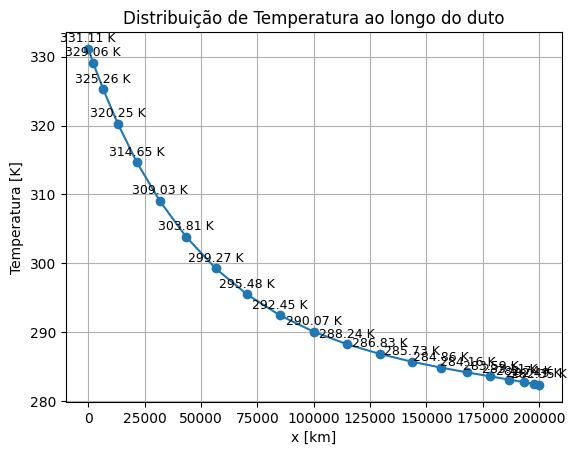

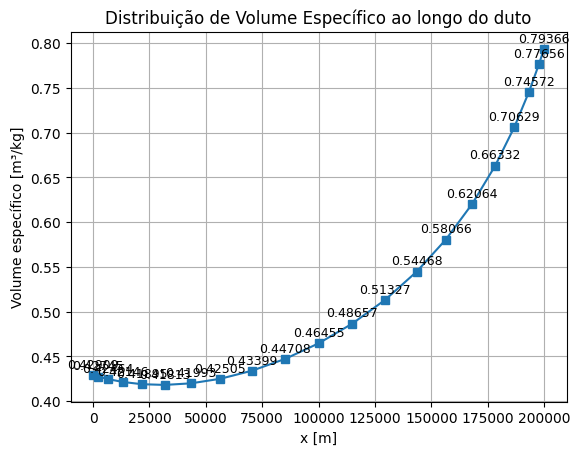

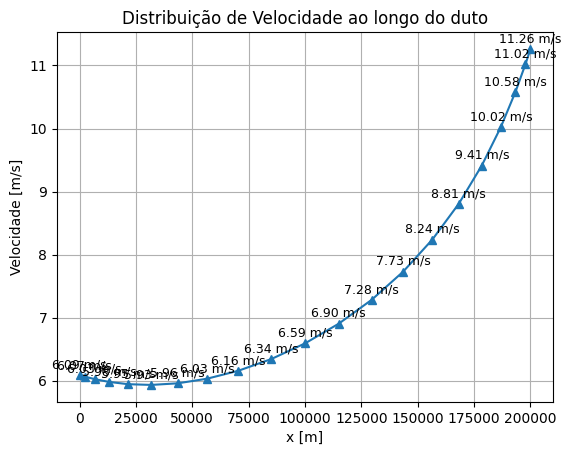

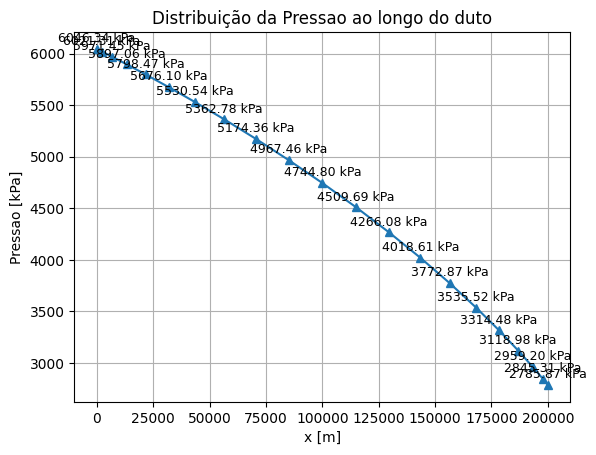

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --- Temperatura (K) ---
plt.figure()
plt.plot(x_avaliar, T_sol_estc, marker='o', linestyle='-')
for xi, Ti in zip(x_avaliar, T_sol_estc):
    plt.annotate(f'{Ti:.2f} K', xy=(xi, Ti), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Temperatura ao longo do duto')
plt.xlabel('x [km]')
plt.ylabel('Temperatura [K]')
plt.grid(True)

# --- Volume específico (m³/kg) ---
plt.figure()
plt.plot(x_avaliar, V_sol_estc, marker='s', linestyle='-')
for xi, Vi in zip(x_avaliar, V_sol_estc):
    plt.annotate(f'{Vi:.5f}', xy=(xi, Vi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Volume Específico ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Volume específico [m³/kg]')
plt.grid(True)

# --- Velocidade (m/s) ---
plt.figure()
plt.plot(x_avaliar, w_sol_estc, marker='^', linestyle='-')
for xi, wi in zip(x_avaliar, w_sol_estc):
    plt.annotate(f'{wi:.2f} m/s', xy=(xi, wi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Velocidade ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Velocidade [m/s]')
plt.grid(True)


plt.figure()
plt.plot(x_avaliar, P_sol_estc, marker='^', linestyle='-')
for xi, Pi in zip(x_avaliar, P_sol_estc):
    plt.annotate(f'{Pi:.2f} kPa', xy=(xi, Pi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição da Pressao ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Pressao [kPa]')
plt.grid(True)

plt.show()


In [8]:
meu_sistema = duto_casadi(gas, visc, compressor=compressor, Lc=200000.0, D=0.42)
# --- Condições iniciais ---
T0 = T_sol_estc
V0 = V_sol_estc
w0 = w_sol_estc
gas_temp = gas.copy_change_conditions(T_sol_estc[-1], None, V_sol_estc[-1], 'gas')
y0 = np.empty(n_nodes * 3)
y0[0::3] = T0
y0[1::3] = V0
y0[2::3] = w0
z0 = z_sol + [rho * A * w_sol_estc[0], gas_temp.P]
y0 = np.array(y0, dtype=float)
z0 = np.array(z0, dtype=float)
print(z0)
u0 = np.array([700.0, 30, 4000, 300.0, 2.1506, 290])
dt = 60
# --- Simulação temporal ---
n_steps = 1500 # número de passos
t_sim = np.linspace(0, n_steps * dt, n_steps)

y_sol = np.zeros((n_steps, len(y0)))

sim = SimuladorDuto(meu_sistema)
resultados = sim.run(y0, z0, u0, 4, 500, [700, 650, 750, 800], 60)
sim.plotar()

[3.15253725e+02 5.14022075e-01 3.14570988e+02 5.28621307e-01
 3.25802623e+02 4.20022620e-01 3.31114889e+02 4.29091510e-01
 5.83790379e-01 3.00000000e+02 4.29091510e-01 3.31114889e+02
 3.20000000e+01 2.78587244e+03]


CasADi - 2025-11-26 12:21:37 WARNING("integrador:daeF failed: NaN detected for output alg, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-11-26 12:21:37 WARNING("integrador:daeF failed: NaN detected for output alg, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-11-26 12:21:37 WARNING("integrador:daeF failed: NaN detected for output alg, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-11-26 12:21:37 WARNING("integrador:daeF failed: NaN detected for output alg, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:393]
CasADi - 2025-11-26 12:21:37 WARNING("integrador:daeF failed: NaN detected for output alg, at (row 9, col 0).") [.../casadi/core/oracle_function.cpp:393]
The residual routine or the linear setup or solve routine had a recoverable error, but IDACalcIC was unable to recover.


RuntimeError: Error in Function::call for 'integrador' [IdasInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'integrador' [IdasInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDACalcIC returned "IDA_NO_RECOVERY". Consult IDAS documentation.

In [ ]:
RNN_train, x_train, y_train, x_min, x_max, y_min, y_max = sim.train_dataset(2)
print(RNN_train)